In [1]:
import random
import os
from urllib import request
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import DebertaTokenizer, DebertaForSequenceClassification
import os
from collections import defaultdict
from sklearn.preprocessing import MultiLabelBinarizer
import pandas as pd
import torch
from torch.utils.data import Dataset
from sklearn.metrics import accuracy_score, f1_score
import numpy as np
from transformers import DebertaForSequenceClassification, Trainer, TrainingArguments
from transformers import AdamW, get_linear_schedule_with_warmup

user="/vol/bitbucket/cx720/cw/nlp/70016-Natural-Language-Processing/"
# user="/vol/bitbucket/xz223/dlenv/NLP/"

In [169]:
class DontPatronizeMe:

    def __init__(self, _train_path, _test_path):
        self.train_path = _train_path
        self.test_path = _test_path
        self.train_task1_df = None
        self.test_set_df = None

    def load_task1(self):
        """
        Load task 1 training set and convert the tags into binary labels. 
        Paragraphs with original labels of 0 or 1 are considered to be negative examples of PCL and will have the label 0 = negative.
        Paragraphs with original labels of 2, 3 or 4 are considered to be positive examples of PCL and will have the label 1 = positive.
        It returns a pandas dataframe with paragraphs and labels.
        """
        rows = []
        with open(self.train_path) as f:
            for line in f.readlines()[4:]:
                par_id = line.strip().split('\t')[0]
                art_id = line.strip().split('\t')[1]
                keyword = line.strip().split('\t')[2]
                country = line.strip().split('\t')[3]
                t = line.strip().split('\t')[4]  # .lower()
                l = line.strip().split('\t')[-1]
                if l == '0' or l == '1':
                    lbin = 0
                else:
                    lbin = 1
                rows.append(
                    {'par_id': par_id,
                     'art_id': art_id,
                     'keyword': keyword,
                     'country': country,
                     'text': t,
                     'label': lbin,
                     'orig_label': l
                     }
                )
        df = pd.DataFrame(rows, columns=['par_id', 'art_id', 'keyword', 'country', 'text', 'label', 'orig_label']) 
        self.train_task1_df = df

    def load_test(self):
        # self.test_df = [line.strip() for line in open(self.test_path)]
        rows = []
        with open(self.test_path) as f:
            for line in f:
                t = line.strip().split('\t')
                rows.append(t)
        self.test_set_df = pd.DataFrame(rows, columns="par_id art_id keyword country text".split())
        return self.test_set_df

In [170]:
def get_test(user):
    _train_path = f'{user}/cw/dontpatronizeme_pcl.tsv'
    _test_path = f'{user}/cw/task4_test.tsv'
    
    dpm = DontPatronizeMe(_train_path, _test_path)
    dpm.load_task1()
    
    train_data = dpm.train_task1_df.copy()
    train_data["par_id"] = train_data["par_id"].astype(str)
    
    dev_parids = pd.read_csv("dev_semeval_parids-labels.csv")
    dev_parids["par_id"] = dev_parids["par_id"].astype(str)
    dev_parid_list = dev_parids["par_id"].unique()

    dev_data = train_data[train_data["par_id"].isin(dev_parid_list)]
    dev_data = dev_data.set_index("par_id").reindex(dev_parids["par_id"]).reset_index()
    
    return dev_data

def get_train(user):
    _train_path = f'{user}/cw/dontpatronizeme_pcl.tsv'
    _test_path = f'{user}/cw/task4_test.tsv'
    
    dpm = DontPatronizeMe(_train_path, _test_path)
    dpm.load_task1()
    
    train_data = dpm.train_task1_df.copy()
    train_data["par_id"] = train_data["par_id"].astype(str)
    
    train_parids = pd.read_csv("train_semeval_parids-labels.csv")
    train_parids["par_id"] = train_parids["par_id"].astype(str)
    train_parid_list = train_parids["par_id"].unique()
    
    train_filtered_data = train_data[train_data["par_id"].isin(train_parid_list)]
    train_filtered_data = train_filtered_data.set_index("par_id").reindex(train_parids["par_id"]).reset_index()
    
    return train_filtered_data

In [171]:
_train_path = f'{user}/cw/dontpatronizeme_pcl.tsv'
_test_path = f'{user}/cw/task4_test.tsv'

dpm = DontPatronizeMe(_train_path, _test_path)
real_test = dpm.load_test()

/vol/bitbucket/cx720/cw/nlp/70016-Natural-Language-Processing//cw/task4_test.tsv


In [173]:
real_test

,par_id,art_id,keyword,country,text
0,t_0,@@7258997,vulnerable,us,"In the meantime , conservatives are working to..."
1,t_1,@@16397324,women,pk,In most poor households with no education chil...
2,t_2,@@16257812,migrant,ca,The real question is not whether immigration i...
3,t_3,@@3509652,migrant,gb,"In total , the country 's immigrant population..."
4,t_4,@@477506,vulnerable,ca,"Members of the church , which is part of Ken C..."
...,...,...,...,...,...
3827,t_3893,@@20319448,migrant,jm,In a letter dated Thursday to European Commiss...
3828,t_3894,@@9990672,poor-families,au,They discovered that poor families with health...
3829,t_3895,@@37984,migrant,ca,"She married at 19 , to Milan ( Emil ) Badovina..."
3830,t_3896,@@9691377,immigrant,us,The United Kingdom is n't going to devolve int...


In [8]:
train_data = get_train(user)
test_data = get_test(user)

In [9]:
test_data

,par_id,art_id,keyword,country,text,label,orig_label
0,4046,@@14767805,hopeless,us,We also know that they can benefit by receivin...,1,3
1,1279,@@7896098,refugee,ng,Pope Francis washed and kissed the feet of Mus...,1,4
2,8330,@@17252299,refugee,ng,Many refugees do n't want to be resettled anyw...,1,2
3,4063,@@3002894,in-need,ie,"""Budding chefs , like """" Fred """" , """" Winston ...",1,4
4,4089,@@25597822,homeless,pk,"""In a 90-degree view of his constituency , one...",1,3
...,...,...,...,...,...,...,...
2089,10462,@@22092971,homeless,gh,"The sad spectacle , which occurred on Saturday...",0,0
2090,10463,@@4676355,refugee,pk,""""""" The Pakistani police came to our house and...",0,0
2091,10464,@@19612634,disabled,ie,"""When Marie O'Donoghue went looking for a spec...",0,0
2092,10465,@@14297363,women,lk,"""Sri Lankan norms and culture inhibit women fr...",0,1


## Test

In [98]:
import torch
from transformers import DebertaForSequenceClassification, DebertaTokenizer
import os

def labels2file(p, outf_path):
	with open(outf_path,'w') as outf:
		for pi in p:
			outf.write(','.join([str(k) for k in pi])+'\n')
            
def run_evaluation(train_test_data, model_name,
                   res_dir="res", ref_dir="ref"):

    model = DebertaForSequenceClassification.from_pretrained("./models/"+model_name)
    tokenizer = DebertaTokenizer.from_pretrained("./tokenizers/"+model_name)
    model.eval()
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    def predict_label(text, model, tokenizer, device):
        inputs = tokenizer(
            text,
            return_tensors="pt",
            padding=True,
            truncation=True,
            max_length=512
        ).to(device)

        with torch.no_grad():
            outputs = model(**inputs)
            logits = outputs.logits
            pred_label = torch.argmax(logits, dim=1).item()
        return pred_label
        
    os.makedirs(f"results/{model_name}/res/", exist_ok=True)
    preds_task1 = []
    
    for i, row in train_test_data.iterrows():
        text = row["text"]
        label_pred = predict_label(text, model, tokenizer, device)
        preds_task1.append([label_pred])
        
    labels2file(preds_task1, os.path.join(f"results/{model_name}/res/", 'task1.txt'))
    
    os.makedirs(f"results/{model_name}/ref/", exist_ok=True)
    gold_labels = train_test_data['label'].tolist()
    gold_labels_nested = [[lbl] for lbl in gold_labels]
    labels2file(gold_labels_nested, f"results/{model_name}/ref/task1.txt")

    os.system(f"python3 evaluation.py results/{model_name}/ results/{model_name}/")
    
    if os.path.exists(f"results/{model_name}/scores.txt"):
        with open(f"results/{model_name}/scores.txt", "r", encoding="utf-8") as f:
            print(f.read())

In [174]:
def run_evaluation_real(train_test_data, model_name,
                   res_dir="res", ref_dir="ref"):

    model = DebertaForSequenceClassification.from_pretrained("./models/"+model_name)
    tokenizer = DebertaTokenizer.from_pretrained("./tokenizers/"+model_name)
    model.eval()
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    def predict_label(text, model, tokenizer, device):
        inputs = tokenizer(
            text,
            return_tensors="pt",
            padding=True,
            truncation=True,
            max_length=512
        ).to(device)

        with torch.no_grad():
            outputs = model(**inputs)
            logits = outputs.logits
            pred_label = torch.argmax(logits, dim=1).item()
        return pred_label
        
    preds_task1 = []
    
    for i, row in train_test_data.iterrows():
        text = row["text"]
        label_pred = predict_label(text, model, tokenizer, device)
        preds_task1.append([label_pred])
        
    labels2file(preds_task1, os.path.join(f"./", 'test.txt'))

In [99]:
import torch
import pandas as pd
from transformers import DebertaForSequenceClassification, DebertaTokenizer

def get_misclassified_df(train_test_data, model_name):
    model_path = f"./models/{model_name}"
    tokenizer_path = f"./tokenizers/{model_name}"
    model = DebertaForSequenceClassification.from_pretrained(model_path)
    tokenizer = DebertaTokenizer.from_pretrained(tokenizer_path)

    model.eval()
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    error_samples = []

    def predict_label(text):
        inputs = tokenizer(
            text,
            return_tensors="pt",
            padding=True,
            truncation=True,
            max_length=512
        ).to(device)

        with torch.no_grad():
            outputs = model(**inputs)
            logits = outputs.logits
            return torch.argmax(logits, dim=1).item()

    for _, row in train_test_data.iterrows():
        gold_label = row["label"]
        pred_label = predict_label(row["text"])

        if pred_label != gold_label:
            error_samples.append({
                "par_id":     row["par_id"],
                "art_id":     row["art_id"],
                "keyword":    row["keyword"],
                "country":    row["country"],
                "text":       row["text"],
                "label":      gold_label,
                "orig_label": row["orig_label"],
                "pred_label": pred_label
            })

    df_errors = pd.DataFrame(error_samples)
    return df_errors


In [175]:
model_name = "deberta_f12"
run_evaluation_real(train_test_data=real_test, model_name=model_name)

In [100]:
wrong_df = get_misclassified_df(test_data, model_name)

In [101]:
wrong_df

,par_id,art_id,keyword,country,text,label,orig_label,pred_label
0,4046,@@14767805,hopeless,us,We also know that they can benefit by receivin...,1,3,0
1,8330,@@17252299,refugee,ng,Many refugees do n't want to be resettled anyw...,1,2,0
2,4089,@@25597822,homeless,pk,"""In a 90-degree view of his constituency , one...",1,3,0
3,432,@@15802146,refugee,nz,He depicts demonstrations by refugees at the b...,1,2,0
4,2001,@@14012804,poor-families,tz,t is remiss not to mention here that not all s...,1,2,0
...,...,...,...,...,...,...,...,...
153,10268,@@24646531,vulnerable,gb,""""""" This new project will see an active engage...",0,0,1
154,10310,@@10161473,homeless,hk,Chan has for some time been giving free meals ...,0,0,1
155,10355,@@23867151,in-need,us,""""""" For more than 100 years , St. Bernard Hosp...",0,0,1
156,10382,@@15138233,immigrant,ng,"""To fulfill her campaign pledge to offer a pat...",0,0,1


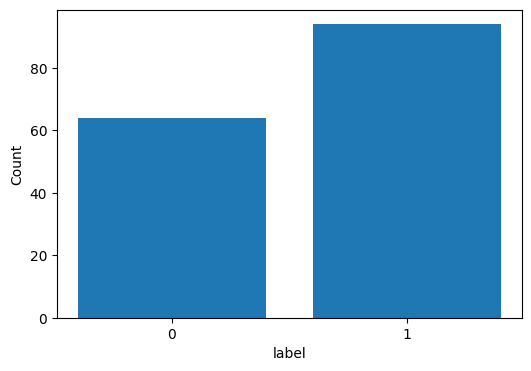

In [102]:
import matplotlib.pyplot as plt

label_counts = wrong_df['label'].value_counts()

count_0 = label_counts.get(0, 0)
count_1 = label_counts.get(1, 0)

x_vals = [0, 1]
y_vals = [count_0, count_1]

plt.figure(figsize=(6, 4))
plt.bar(x_vals, y_vals)
plt.xlabel("label")
plt.ylabel("Count")
# plt.title("Distribution of label (Only 0 and 1)")
plt.xticks(x_vals, ['0', '1'])  

plt.show()


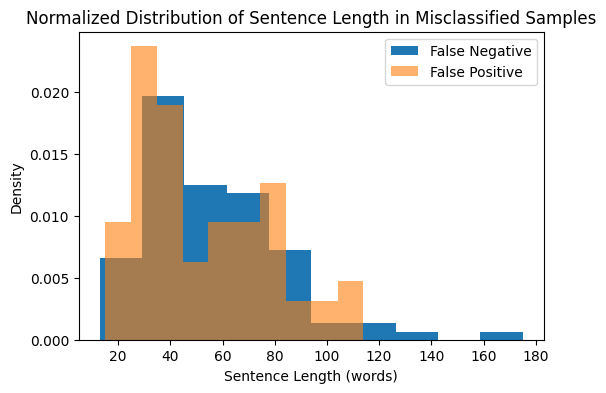

In [103]:
import matplotlib.pyplot as plt

wrong_df['text_length'] = wrong_df['text'].apply(lambda x: len(x.split()))

fp_lengths = wrong_df[wrong_df['label'] == 0]['text_length']
fn_lengths = wrong_df[wrong_df['label'] == 1]['text_length']

plt.figure(figsize=(6, 4))

plt.hist(fn_lengths, bins=10, density=True, alpha=1, label="False Negative", histtype='stepfilled')

plt.hist(fp_lengths, bins=10, density=True, alpha=0.6, label="False Positive", histtype='stepfilled')

plt.xlabel("Sentence Length (words)")
plt.ylabel("Density")
plt.title("Normalized Distribution of Sentence Length in Misclassified Samples")
plt.legend()
plt.show()


In [104]:
wrong_df

,par_id,art_id,keyword,country,text,label,orig_label,pred_label,text_length
0,4046,@@14767805,hopeless,us,We also know that they can benefit by receivin...,1,3,0,85
1,8330,@@17252299,refugee,ng,Many refugees do n't want to be resettled anyw...,1,2,0,16
2,4089,@@25597822,homeless,pk,"""In a 90-degree view of his constituency , one...",1,3,0,70
3,432,@@15802146,refugee,nz,He depicts demonstrations by refugees at the b...,1,2,0,40
4,2001,@@14012804,poor-families,tz,t is remiss not to mention here that not all s...,1,2,0,27
...,...,...,...,...,...,...,...,...,...
153,10268,@@24646531,vulnerable,gb,""""""" This new project will see an active engage...",0,0,1,31
154,10310,@@10161473,homeless,hk,Chan has for some time been giving free meals ...,0,0,1,28
155,10355,@@23867151,in-need,us,""""""" For more than 100 years , St. Bernard Hosp...",0,0,1,38
156,10382,@@15138233,immigrant,ng,"""To fulfill her campaign pledge to offer a pat...",0,0,1,38


In [113]:
total_count_1_all = len(test_data[test_data['label'] == 1]) 
total_count_0_all = len(test_data[test_data['label'] == 0]) 

mis_count_1_all = len(wrong_df[wrong_df['label'] == 1])     
mis_count_0_all = len(wrong_df[wrong_df['label'] == 0])     

TP_all = total_count_1_all - mis_count_1_all  
FP_all = mis_count_0_all                      
FN_all = mis_count_1_all                      
TN_all = total_count_0_all - mis_count_0_all 

accuracy_all = (TP_all + TN_all) / (TP_all + TN_all + FP_all + FN_all + 1e-7)
precision_all = TP_all / (TP_all + FP_all + 1e-7)
recall_all    = TP_all / (TP_all + FN_all + 1e-7)
f1_all        = 2 * (precision_all * recall_all) / (precision_all + recall_all + 1e-7)
specificity_all = TN_all / (TN_all + FP_all + 1e-7)

print("=== Overall Confusion Matrix Statistics ===")
print(f"TP: {TP_all}")
print(f"FP: {FP_all}")
print(f"FN: {FN_all}")
print(f"TN: {TN_all}")
print("\n=== Evaluation Metrics ===")
print(f"Accuracy:    {accuracy_all:.4f}")
print(f"Precision:   {precision_all:.4f}  (positive predictive value)")
print(f"Recall:      {recall_all:.4f}     (sensitivity)")
print(f"F1-score:    {f1_all:.4f}")
print(f"Specificity: {specificity_all:.4f}")

=== Overall Confusion Matrix Statistics ===
TP: 105
FP: 64
FN: 94
TN: 1831

=== Evaluation Metrics ===
Accuracy:    0.9245
Precision:   0.6213  (positive predictive value)
Recall:      0.5276     (sensitivity)
F1-score:    0.5707
Specificity: 0.9662


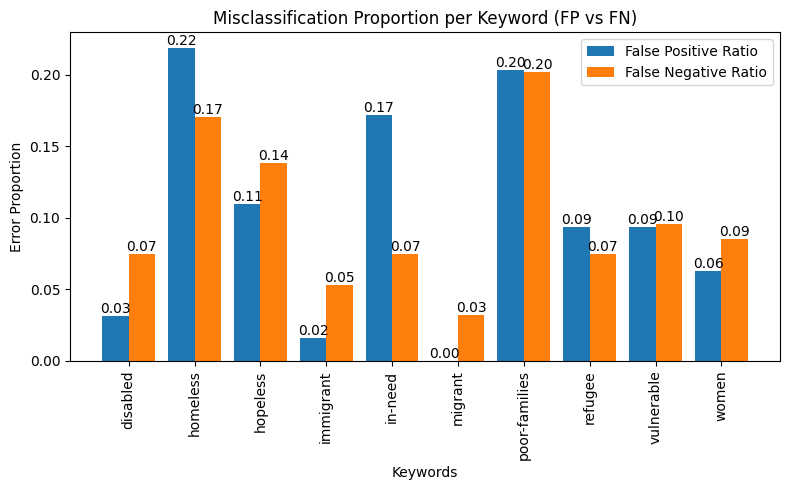

In [122]:
import matplotlib.pyplot as plt
import numpy as np

keywords = sorted(test_data['keyword'].unique())
fp_ratios = []
fn_ratios = []

for kw in keywords:
    total_count_0 = len(test_data[(test_data['keyword'] == kw) & (test_data['label'] == 0)])
    mis_count_0 = len(wrong_df[(wrong_df['keyword'] == kw) & (wrong_df['label'] == 0)])
    ratio_fp = mis_count_0 / FP_all if total_count_0 > 0 else 0
    fp_ratios.append(ratio_fp)
    total_count_1 = len(test_data[(test_data['keyword'] == kw) & (test_data['label'] == 1)])
    mis_count_1 = len(wrong_df[(wrong_df['keyword'] == kw) & (wrong_df['label'] == 1)])
    ratio_fn = mis_count_1 / FN_all if total_count_1 > 0 else 0
    fn_ratios.append(ratio_fn)

x = np.arange(len(keywords))
bar_width = 0.4

plt.figure(figsize=(8, 5))
bars_fp = plt.bar(x - bar_width/2, fp_ratios, width=bar_width, label='False Positive Ratio')
bars_fn = plt.bar(x + bar_width/2, fn_ratios, width=bar_width, label='False Negative Ratio')

plt.xticks(x, keywords, rotation=90)
plt.xlabel("Keywords")
plt.ylabel("Error Proportion")
plt.title("Misclassification Proportion per Keyword (FP vs FN)")
plt.legend()
plt.tight_layout()

for b in bars_fp:
    h = b.get_height()
    plt.text(b.get_x() + b.get_width()/2, h, f"{h:.2f}", ha='center', va='bottom')
for b in bars_fn:
    h = b.get_height()
    plt.text(b.get_x() + b.get_width()/2, h, f"{h:.2f}", ha='center', va='bottom')

plt.show()


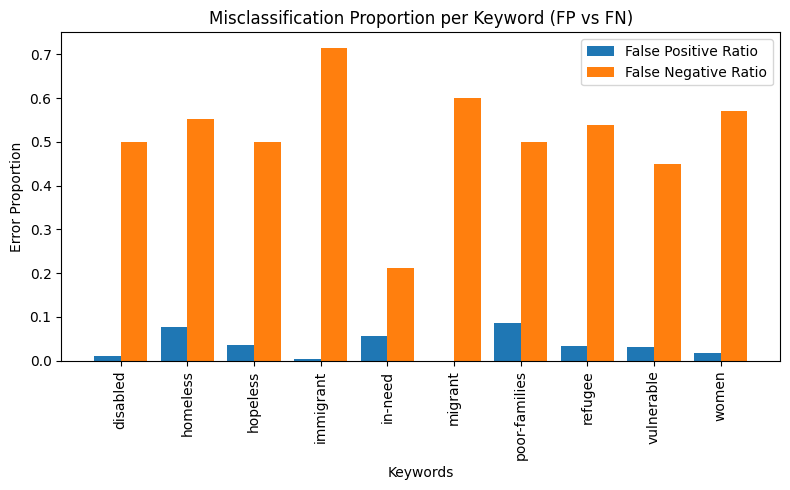

In [121]:
import matplotlib.pyplot as plt
import numpy as np

keywords = sorted(test_data['keyword'].unique())

fp_ratios = []
fn_ratios = []

for kw in keywords:
    total_count_0 = len(test_data[(test_data['keyword'] == kw) & (test_data['label'] == 0)])
    mis_count_0 = len(wrong_df[(wrong_df['keyword'] == kw) & (wrong_df['label'] == 0)])
    ratio_fp = mis_count_0 / total_count_0 if total_count_0 > 0 else 0
    fp_ratios.append(ratio_fp)

    total_count_1 = len(test_data[(test_data['keyword'] == kw) & (test_data['label'] == 1)])
    mis_count_1 = len(wrong_df[(wrong_df['keyword'] == kw) & (wrong_df['label'] == 1)])
    ratio_fn = mis_count_1 / total_count_1 if total_count_1 > 0 else 0
    fn_ratios.append(ratio_fn)

x = np.arange(len(keywords))
bar_width = 0.4

plt.figure(figsize=(8, 5))
plt.bar(x - bar_width/2, fp_ratios, width=bar_width, label='False Positive Ratio')
plt.bar(x + bar_width/2, fn_ratios, width=bar_width, label='False Negative Ratio')

plt.xticks(x, keywords, rotation=90)
plt.xlabel("Keywords")
plt.ylabel("Error Proportion")
plt.title("Misclassification Proportion per Keyword (FP vs FN)")
plt.legend()
plt.tight_layout()
plt.show()


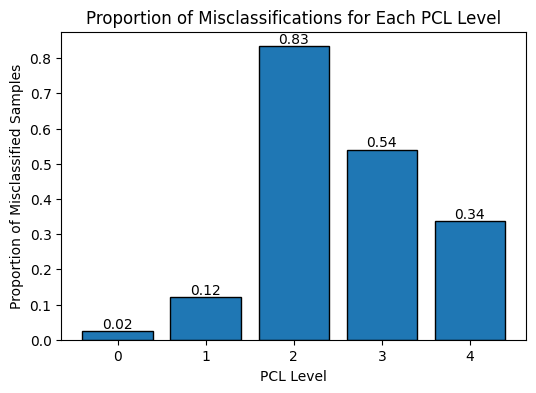

In [138]:
import matplotlib.pyplot as plt

test_label_counts = test_data['orig_label'].value_counts()

wrong_label_counts = wrong_df['orig_label'].value_counts()

all_labels = sorted(set(test_label_counts.index).union(set(wrong_label_counts.index)))

ratios = []
for lbl in all_labels:
    total_count = test_label_counts.get(lbl, 0)  
    wrong_count = wrong_label_counts.get(lbl, 0) 
    if total_count == 0:
        ratio = 0
    else:
        ratio = wrong_count / total_count
    ratios.append(ratio)

plt.figure(figsize=(6, 4))
bars = plt.bar(all_labels, ratios, edgecolor='black')

plt.xlabel("PCL Level")
plt.ylabel("Proportion of Misclassified Samples")
plt.title("Proportion of Misclassifications for Each PCL Level")

plt.xticks(all_labels)

for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f"{height:.2f}", ha='center', va='bottom')

plt.show()


In [126]:
test_label_counts = test_data['orig_label'].value_counts()
test_label_counts

orig_label
0    1704
1     191
4      92
3      89
2      18
Name: count, dtype: int64

In [21]:
# model_names = os.listdir("./tokenizers")
# for model_name in model_names:
#     print(f"Evaluating model: {model_name}")
#     run_evaluation(train_test_data=test_data, model_name=model_name)

Evaluating model: deberta_wd_cosine
task1_precision:0.639751552795031
task1_recall:0.5175879396984925
task1_f1:0.5722222222222222

Evaluating model: deberta_lr_1e-05
task1_precision:0.6862745098039216
task1_recall:0.5276381909547738
task1_f1:0.5965909090909091

Evaluating model: deberta_DA_1
task1_precision:0.6048387096774194
task1_recall:0.3768844221105528
task1_f1:0.46439628482972134

Evaluating model: deberta_DA_6
task1_precision:0.43309859154929575
task1_recall:0.6180904522613065
task1_f1:0.5093167701863354

Evaluating model: deberta_f4
task1_precision:0.6242424242424243
task1_recall:0.5175879396984925
task1_f1:0.5659340659340659

Evaluating model: deberta_f13
task1_precision:0.5577889447236181
task1_recall:0.5577889447236181
task1_f1:0.5577889447236181

Evaluating model: deberta_DA_2
task1_precision:0.5704697986577181
task1_recall:0.4271356783919598
task1_f1:0.4885057471264368

Evaluating model: deberta_DA_5
task1_precision:0.5579399141630901
task1_recall:0.6532663316582915
task1_

/vol/bitbucket/cx720/myvenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


task1_precision:0.0
task1_recall:0.0
task1_f1:0.0

Evaluating model: deberta_lr_2e-05
task1_precision:0.6666666666666666
task1_recall:0.4623115577889447
task1_f1:0.5459940652818991

Evaluating model: deberta_DA_3
task1_precision:0.6518518518518519
task1_recall:0.44221105527638194
task1_f1:0.5269461077844312

Evaluating model: deberta_wd_linear
task1_precision:0.6363636363636364
task1_recall:0.49246231155778897
task1_f1:0.5552407932011332

